In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, VotingClassifier, AdaBoostClassifier


import os

from numpy import sqrt

from os.path import isfile

import pickle

import time

import matplotlib.pyplot as plt

import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass

import warnings

from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)

In [2]:
def train_decision_tree(file_path: str, X_train: pd.DataFrame, y_train: pd.DataFrame, r_state=42, metric='precision'):
    train_model = DecisionTreeClassifier(random_state=r_state)

    if isfile(file_path):
        with open(file_path, 'rb') as m_file:
            train_model = pickle.load(m_file)
    else:
        start_time = time.time()

        params = [
            {
                'criterion': ['gini', 'entropy'],
                'splitter': ['best', 'random'],
                'max_depth': np.concatenate(np.arange(1, 15, 1), None),
                'max_features': ['auto', 'sqrt', 'log2', None],
                'class_weight': ['balanced', None]
            }
        ]

        cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=r_state)

        grid_search = GridSearchCV(
            estimator=train_model,
            param_grid=params,
            cv=cross_val,
            n_jobs=-1,
            scoring=metric,
            error_score='raise',
            verbose=1)

        warnings.warn = warn
        
        result = grid_search.fit(X_train, y_train)

        train_model = result.best_estimator_

        print("Training took {:.2f}s.".format((time.time() - start_time)))
        
        print("\nThe best model hyper parameters are:")

        for hyper_p in result.best_params_:
            print("\t-{}: {}".format(str(hyper_p), result.best_params_[hyper_p]))

        with open(file_path, 'wb') as m_file:
            pickle.dump(train_model, m_file)

    return train_model

In [3]:
preg = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2] \
    else 0 if x  >= 0 and x < 3 else 1 if x >= 3 and x < 7 else 2

glucose = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2, 3, 4, 5] \
    else 0 if x >= 0 and x < 89.2 else 1 if x >= 89.2 and x < 107.2 else 2 if x >= 107.2 and x < 123.2 else 3 if x >= 123.2 and x < 143.2 else 4 if x >= 143.2 and x < 155.2 else 5

blood_p = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2] \
    else 0 if x >= 0 and x < 76.2 else 1 if x >= 76.2 and x < 98.2 else 2 

skin_t = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2] \
    else 0 if x >= 0 and x < 26 else 1 if x >= 26 and x < 33 else 2

insulin = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2, 3] \
    else 0 if x >= 0 and x < 111 else 1 if x >= 111 and x < 151 else 2 if x >= 151 and x < 241 else 3 

bmi = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2, 3, 4] \
    else 0 if x >= 0 and x < 22.815 else 1 if x >= 22.815 and x < 26.841 else 2 if x >= 26.841 and x < 33.551 else 3 if x >= 33.551 and x < 35.563 else 4 

dpf = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2, 3, 4] \
    else 0 if x >= 0 and x< .245 else 1 if x >= .245 and x < .526 else 2 if x >= .526 and x < .806 else 3 if x >= .806 and x < 1.111 else 4

age = lambda x: np.NaN if np.isnan(x) else x if x in [0, 1, 2, 3, 4] \
    else 0 if x >= 21 and x < 25 else 1 if x >= 25 and x < 31 else 2 if x >= 31 and x < 41 else 3 if x >= 41 and x < 56 else 4


def construct_df(in_df: pd.DataFrame, in_columns: list):
    result_df = pd.DataFrame(columns=in_columns)
    
    result_df['Pregnancies'] = in_df['Pregnancies'].map(preg)
    result_df['Glucose'] = in_df['Glucose'].map(glucose)
    result_df['BloodPressure'] = in_df['BloodPressure'].map(blood_p)
    result_df['SkinThickness'] = in_df['SkinThickness'].map(skin_t)
    result_df['Insulin'] = in_df['Insulin'].map(insulin)
    result_df['BMI'] = in_df['BMI'].map(bmi)
    result_df['DiabetesPedigreeFunction'] = in_df['DiabetesPedigreeFunction'].map(dpf)
    result_df['Age'] = in_df['Age'].map(age)
    
    return result_df
  

## **Источник данных.**

Насколько я понял, изначально датасет был собран в рамках исследования <a href="https://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC2245318&blobtype=pdf">"Using the ADAP Learning Algorithm to Forecastthe Onset of Diabetes Mellitus"</a>

По крайней мере, я не нашел формулы и описания DiabetesPedigreeFunction больше нигде.

Полезно знать, что <a href="https://ru.wikipedia.org/wiki/%D0%9F%D0%B8%D0%BC%D0%B0">индейцы племеи Пима</a> имеют ненормально высокий уровень заболеваемости диабетом второго типа.

## **Импорт данных.**

In [4]:
src_df = pd.read_csv(filepath_or_buffer='./data/pima-indians-diabetes.csv')

In [5]:
src_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Class                       0
dtype: int64

In [6]:
src_df.drop_duplicates(inplace=True)

In [7]:
src_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


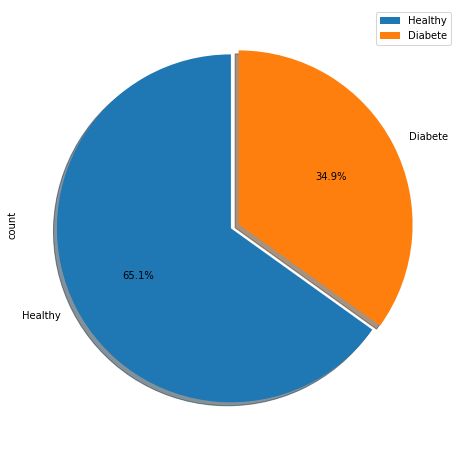

In [8]:
class_pie = pd.DataFrame(
    {'count': [src_df['Class'].isin([0]).sum(), src_df['Class'].isin([1]).sum(),]}, 
    index=['Healthy','Diabete']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=True, startangle=90, explode=(0.05, 0.00))

In [9]:
src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [10]:
src_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Class                         0
dtype: int64

In [11]:
src_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Баланс классов не идеален, но рабочий.

Не имеют смысла нулевые значения в Glucose, BloodPressure, SkinThikness, Insulin и BMI. Придется их заменить на NaN и импутировать.

Для импутации я применю KNNImputer. *В этой работе я не буду приводить исследование (оно было сделано в предыдущем варианте), но $R^2$ оценка составила 0.9-0.95.*

In [12]:
work_cols = src_df.drop('Class', axis=1).columns
src_df_predictors = src_df.drop('Class', axis=1)
src_df_class = src_df[['Class']]

In [13]:
knn_imputer = KNNImputer()

In [14]:
src_imputed = knn_imputer.fit_transform(src_df_predictors)
work_imputed_df = pd.DataFrame(data=src_imputed, columns=work_cols)

Я хочу добавить категории из оригинального исследования. Интересно, как это повлияет на точность модели.

In [15]:
work_constructed_df = construct_df(work_imputed_df, work_cols)

In [16]:
work_imputed_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.598177,30.496543,44.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,72.383333,12.206858,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.104427,9.422976,7.000,23.00000,29.0000,35.00000,99.00
Insulin,768.0,153.061979,98.271557,14.000,87.90000,132.9000,190.15000,846.00
BMI,768.0,32.424922,6.885871,18.200,27.50000,32.0900,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


In [17]:
work_constructed_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,1.209635,0.674792,0.0,1.0,1.0,2.0,2.0
Glucose,768.0,2.299479,1.596574,0.0,1.0,2.0,3.0,5.0
BloodPressure,768.0,0.359375,0.521772,0.0,0.0,0.0,1.0,2.0
SkinThickness,768.0,0.972656,0.823724,0.0,0.0,1.0,2.0,2.0
Insulin,768.0,1.154948,1.056773,0.0,0.0,1.0,2.0,3.0
BMI,768.0,2.420573,1.235690,0.0,2.0,2.0,4.0,4.0
DiabetesPedigreeFunction,768.0,1.273438,1.087189,0.0,0.0,1.0,2.0,4.0
Age,768.0,1.489583,1.260118,0.0,0.0,1.0,3.0,4.0


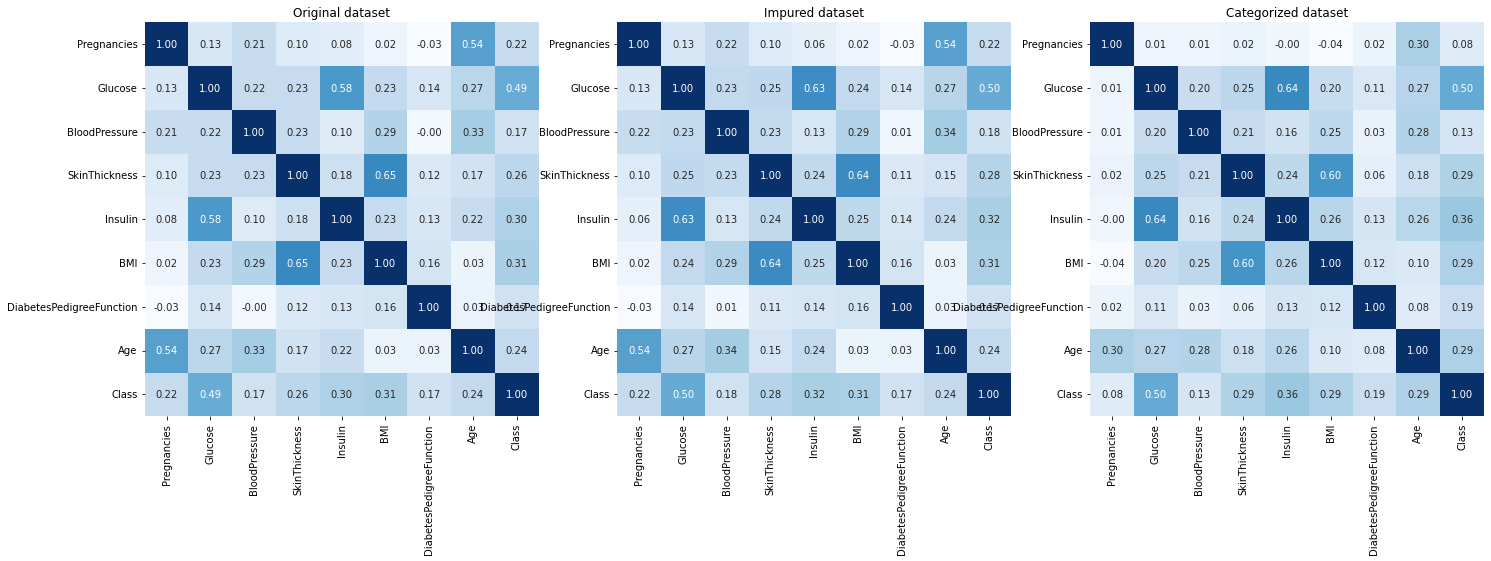

In [18]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
plt.title('Original dataset')
sns.heatmap(src_df.corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)


plt.subplot(132)
plt.title('Impured dataset')
sns.heatmap(work_imputed_df.join(src_df_class).corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.subplot(133) 
plt.title('Categorized dataset')
sns.heatmap(work_constructed_df.join(src_df_class).corr(), annot=True, fmt='.2f', square=True, cmap = 'Blues', cbar=False)

plt.show()

Импутация не изменила корреляции между предикторами, а вот категоризация свела к нулю корреляцию количества беременностей, кроме возраста. Что не выглядит нелогичным.

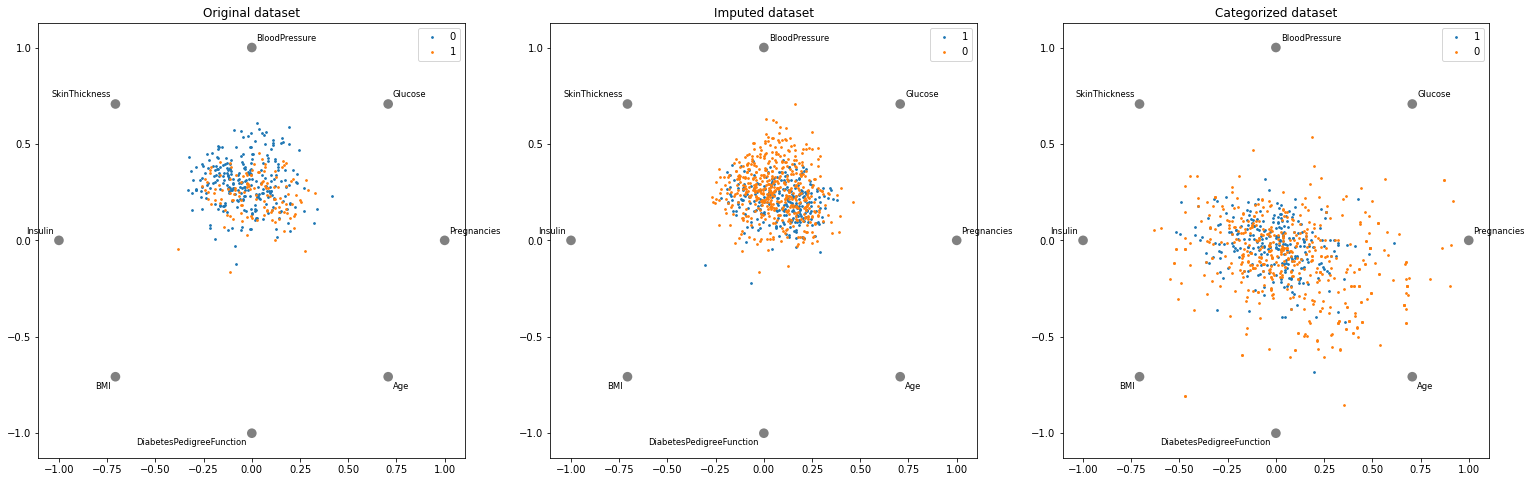

In [19]:
fig = plt.figure(figsize=(26,8))

plt.subplot(131)
plt.title('Original dataset')
pd.plotting.radviz(frame=src_df.dropna(axis=0), class_column='Class', color=sns.color_palette(), s=3)

plt.subplot(132)
plt.title('Imputed dataset')
pd.plotting.radviz(frame=work_imputed_df.join(src_df_class), class_column='Class', color=sns.color_palette(), s=3)

plt.subplot(133) 
plt.title('Categorized dataset')
pd.plotting.radviz(frame=work_constructed_df.join(src_df_class), class_column='Class', color=sns.color_palette(), s=3)

plt.show()

Интересно, что категоризация привела к уменьшению плотности данных. Что должно приести к улучшению точности классификаторов.

# **Decision Tree**

Хорошо известно, что деревья склонны к переобучению. Есть два подхода для решения этой проблемы. ***Pre pruning и Post pruning.*** Если первая методика хорошо известна, то Post pruning описана значительно меньше.

Я попробую применить обе методики на импутированном и категоризированном датасетах и попробую сравнить результаты.

In [20]:
X_imputed_train, X_imputed_test, y_imputed_train, y_imputed_test = train_test_split(work_imputed_df, src_df_class, test_size=0.2, shuffle=True, random_state=42, stratify=src_df_class)
X_constructed_train, X_constructed_test, y_constructed_train, y_constructed_test = train_test_split(work_constructed_df, src_df_class, test_size=0.2, shuffle=True, random_state=42, stratify=src_df_class)

***Pre pruned Decision Tree***

In [21]:
model_tree_imputed_pre_pruned = train_decision_tree('./data/models/v2/model_tree_imputed_pre_pruned.pkl', X_imputed_train, y_imputed_train, metric='accuracy')

In [22]:
model_tree_constructed_pre_pruned = train_decision_tree('./data/models/v2/model_tree_constructed_pre_pruned.pkl', X_constructed_train, y_constructed_train, metric='accuracy')

In [23]:
class_labels = {0:'Healthy', 1:'Diabete'}

In [24]:
pre_pruned_imputed_report = classification_report(
    y_true=y_imputed_test,
    y_pred=model_tree_imputed_pre_pruned.predict(X_imputed_test), 
    output_dict=True
)

pre_pruned_constructed_report = classification_report(
    y_true=y_constructed_test,
    y_pred=model_tree_constructed_pre_pruned.predict(X_constructed_test), 
    output_dict=True
)

***Post pruned Decision Tree***

In [25]:
model_tree_imputed_post_pruned = DecisionTreeClassifier(random_state=42)
model_tree_constructed_post_pruned = DecisionTreeClassifier(random_state=42)

In [26]:
imputed_path = model_tree_imputed_post_pruned.cost_complexity_pruning_path(X_imputed_train, y_imputed_train)
imputed_ccp_alphas, imputed_impurities = imputed_path.ccp_alphas, imputed_path.impurities

constructed_path = model_tree_constructed_post_pruned.cost_complexity_pruning_path(X_constructed_train, y_constructed_train)
constructed_ccp_alphas, constructed_impurities = constructed_path.ccp_alphas, constructed_path.impurities

In [27]:
imputed_clfs = []
constructed_clfs = []

for ccp_alpha in imputed_ccp_alphas:
    tree_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree_clf.fit(X_imputed_train, y_imputed_train)
    imputed_clfs.append(tree_clf)

for ccp_alpha in constructed_ccp_alphas:
    tree_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree_clf.fit(X_constructed_train, y_constructed_train)
    constructed_clfs.append(tree_clf)

In [28]:
imputed_train_scores = [clf.score(X_imputed_train, y_imputed_train) for clf in imputed_clfs]
imputed_test_scores = [clf.score(X_imputed_test, y_imputed_test) for clf in imputed_clfs]

constructed_train_scores = [clf.score(X_constructed_train, y_constructed_train) for clf in constructed_clfs]
constructed_test_scores = [clf.score(X_constructed_test, y_constructed_test) for clf in constructed_clfs]

In [29]:
imputed_scores = np.array(list(zip(imputed_ccp_alphas, imputed_train_scores, imputed_test_scores)))
constructed_scores = np.array(list(zip(constructed_ccp_alphas, constructed_train_scores, constructed_test_scores)))

In [30]:
imputed_best_alpha = imputed_scores[np.argmax(imputed_scores[:, 2])][0]
constructed_best_alpha = constructed_scores[np.argmax(constructed_scores[:, 2])][0]

In [31]:
model_tree_imputed_post_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=imputed_best_alpha)
model_tree_constructed_post_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=constructed_best_alpha)

In [32]:
model_tree_imputed_post_pruned.fit(X_imputed_train, y_imputed_train)
model_tree_constructed_post_pruned.fit(X_constructed_train, y_constructed_train)

post_pruned_imputed_report = classification_report(
    y_true=y_imputed_test,
    y_pred=model_tree_imputed_post_pruned.predict(X_imputed_test), 
    output_dict=True
)

post_pruned_constructed_report = classification_report(
    y_true=y_constructed_test,
    y_pred=model_tree_constructed_post_pruned.predict(X_constructed_test), 
    output_dict=True
)

***Сравнение деревьев.***

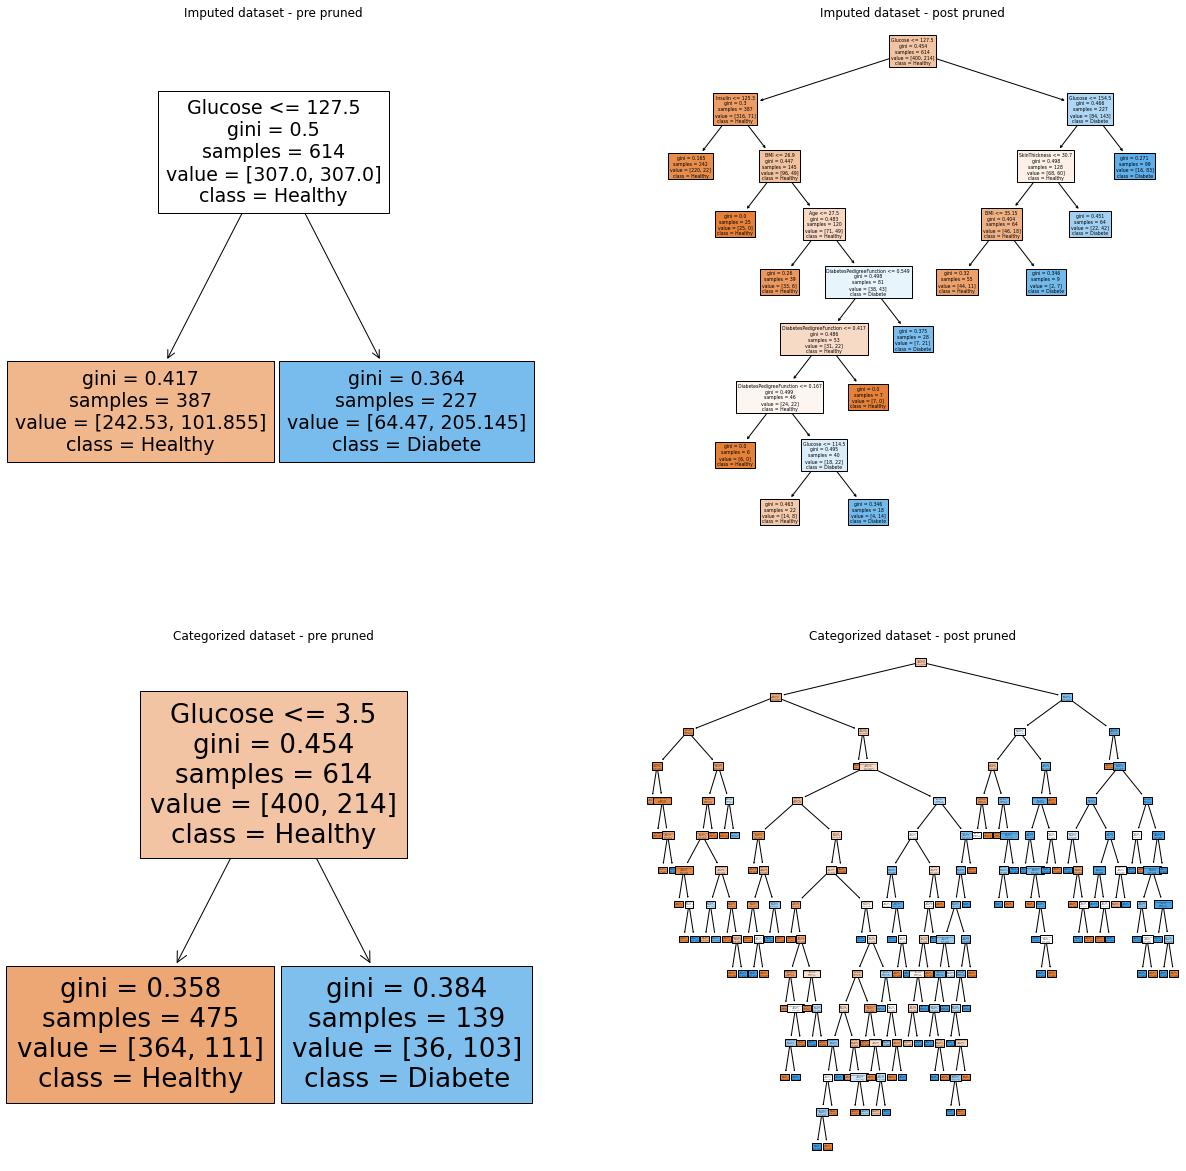

In [33]:
fig = plt.figure(figsize=(21, 21))

plt.subplot(221)
plot_tree(model_tree_imputed_pre_pruned, feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Imputed dataset - pre pruned')

plt.subplot(222)
plot_tree(model_tree_imputed_post_pruned, feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Imputed dataset - post pruned')

plt.subplot(223)
plot_tree(model_tree_constructed_pre_pruned, feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Categorized dataset - pre pruned')

plt.subplot(224)
plot_tree(model_tree_constructed_post_pruned, feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Categorized dataset - post pruned')

plt.show()

Хорошо видно, что Post pruning создает гораздо более интересные деревья. Как минимум, это вовлекает в работу большее количество предикторов. 

<a href="./data/img/decision_tree_cat.svg">Decision Tree categorized</a> <br>
<a href="./data/img/decision_tree_imp.svg">Decision Tree imputed</a>

In [34]:
tree_imputed_pre_pruned_perm = PermutationImportance(model_tree_imputed_pre_pruned, random_state=42, scoring='accuracy', n_iter=20).fit(X_imputed_test, y_imputed_test)
eli5.explain_weights(tree_imputed_pre_pruned_perm, feature_names=work_imputed_df.columns.values)

Weight,Feature
0.1662 ± 0.0629,Glucose
0 ± 0.0000,Age
0 ± 0.0000,DiabetesPedigreeFunction
0 ± 0.0000,BMI
0 ± 0.0000,Insulin
0 ± 0.0000,SkinThickness
0 ± 0.0000,BloodPressure
0 ± 0.0000,Pregnancies


In [35]:
tree_imputed_post_pruned_perm = PermutationImportance(model_tree_imputed_post_pruned, random_state=42, scoring='accuracy', n_iter=20).fit(X_imputed_test, y_imputed_test)
eli5.explain_weights(tree_imputed_post_pruned_perm, feature_names=work_imputed_df.columns.values)

Weight,Feature
0.1010 ± 0.0630,Glucose
0.0195 ± 0.0243,BMI
0.0153 ± 0.0194,Age
0.0146 ± 0.0343,Insulin
0.0058 ± 0.0246,DiabetesPedigreeFunction
0.0023 ± 0.0291,SkinThickness
0 ± 0.0000,BloodPressure
0 ± 0.0000,Pregnancies


In [36]:
tree_constructed_pre_pruned_perm = PermutationImportance(model_tree_constructed_pre_pruned, random_state=42, scoring='accuracy', n_iter=20).fit(X_constructed_test, y_constructed_test)
eli5.explain_weights(tree_constructed_pre_pruned_perm, feature_names=work_imputed_df.columns.values)

Weight,Feature
0.1442 ± 0.0532,Glucose
0 ± 0.0000,Age
0 ± 0.0000,DiabetesPedigreeFunction
0 ± 0.0000,BMI
0 ± 0.0000,Insulin
0 ± 0.0000,SkinThickness
0 ± 0.0000,BloodPressure
0 ± 0.0000,Pregnancies


In [37]:
tree_constructed_post_pruned_perm = PermutationImportance(model_tree_constructed_post_pruned, random_state=42, scoring='accuracy', n_iter=20).fit(X_constructed_test, y_constructed_test)
eli5.explain_weights(tree_constructed_post_pruned_perm, feature_names=work_imputed_df.columns.values)

Weight,Feature
0.0669 ± 0.0674,Glucose
0.0526 ± 0.0503,Age
0.0123 ± 0.0331,BMI
0.0055 ± 0.0273,BloodPressure
0.0010 ± 0.0282,SkinThickness
-0.0101 ± 0.0258,DiabetesPedigreeFunction
-0.0175 ± 0.0341,Insulin
-0.0240 ± 0.0336,Pregnancies


Из исследования пермутации, также как и из самого дерева, видно максимальное использование предикторов моделью с Post pruning и категориальными данными.

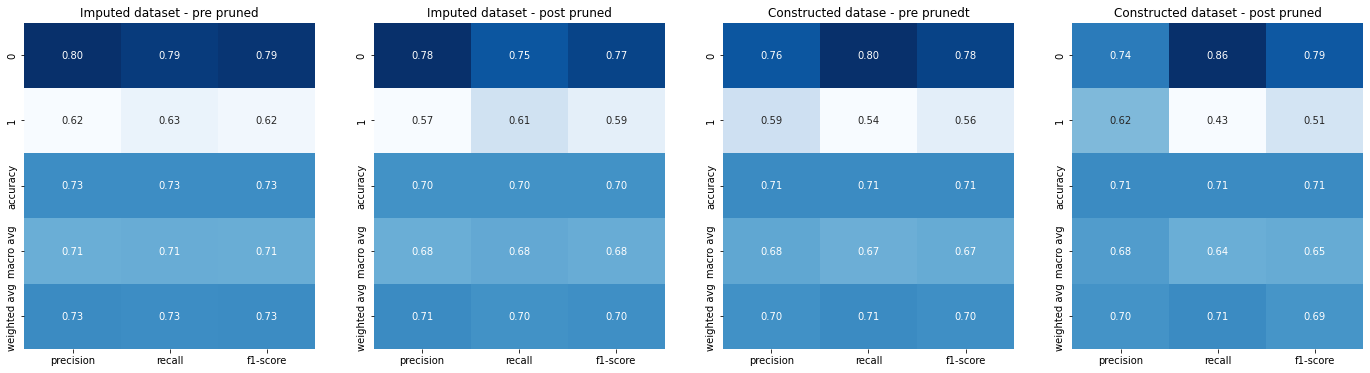

In [38]:
fig = plt.figure(figsize=(24, 6))

plt.subplot(141)
plt.title('Imputed dataset - pre pruned')
sns.heatmap(pd.DataFrame(post_pruned_imputed_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False)

plt.subplot(142)
plt.title('Imputed dataset - post pruned')
sns.heatmap(pd.DataFrame(pre_pruned_imputed_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False)

plt.subplot(143)
plt.title('Constructed datase - pre prunedt')
sns.heatmap(pd.DataFrame(post_pruned_constructed_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False)

plt.subplot(144)
plt.title('Constructed dataset - post pruned')
sns.heatmap(pd.DataFrame(pre_pruned_constructed_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False)

plt.show()

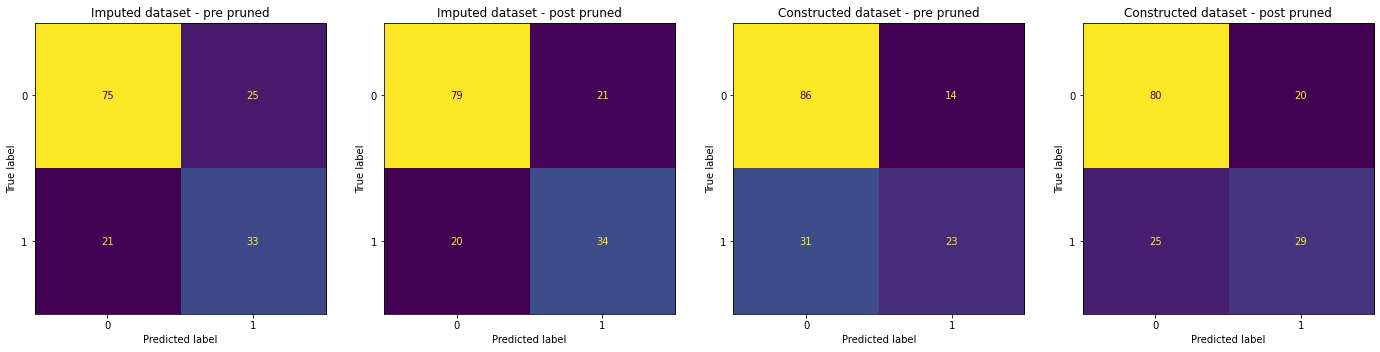

In [39]:
f, ax = plt.subplots(1, 4, figsize=(24, 6))

axes = ax.flatten()

axes[0].set_title('Imputed dataset - pre pruned')
axes[1].set_title('Imputed dataset - post pruned')
axes[2].set_title('Constructed dataset - pre pruned')
axes[3].set_title('Constructed dataset - post pruned')

ConfusionMatrixDisplay.from_estimator(estimator=model_tree_imputed_pre_pruned, X=X_imputed_test, y=y_imputed_test, ax=axes[0], colorbar=False)
ConfusionMatrixDisplay.from_estimator(estimator=model_tree_imputed_post_pruned, X=X_imputed_test, y=y_imputed_test, ax=axes[1], colorbar=False)

ConfusionMatrixDisplay.from_estimator(estimator=model_tree_constructed_pre_pruned, X=X_constructed_test, y=y_constructed_test, ax=axes[2], colorbar=False)
ConfusionMatrixDisplay.from_estimator(estimator=model_tree_constructed_post_pruned, X=X_constructed_test, y=y_constructed_test, ax=axes[3], colorbar=False)

plt.show()

Поскольу модель должна работать с медицинскими данными, как таковая точность или ROC-AUC мало о чем говорят. 

Важно как можно точнее выделить больных и как можно меньше отправить на дообследование здоровых людей.

В дальнейшем я буду использовать категориальные данные. Во-первых они менее плотные, во-вторых для SVM и KNN мне всё равно придется стандартизировать данные.

## **Методика дальнейшего исследования**

Я не буду подробно останавливаться на каждом из классификаторов, поскольку там всё довольно очевидно. После подбора гиперпараметров я сведу все показатели в одном месте для наглядности. И попробую построить ансамбли, т.к. каждая из моделей по отдельности всё равно не даст высокой точности. Для общей оценки алгоритмов буду использовать AUC score.

## **Random Forest**

In [40]:
model_random_forest = RandomForestClassifier(random_state=42, n_estimators=250)

model_random_forest.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())

RandomForestClassifier(n_estimators=250, random_state=42)

In [41]:
random_forest_report = classification_report(
    y_true=y_constructed_test,
    y_pred=model_random_forest.predict(X_constructed_test), 
    output_dict=True
)

Тут из интересного - можно построить несколько деревьев из леса. Строить все 250 не имеет смысла.

In [42]:
random_forest_accs = []

for cur_estimator_idx in range(250):
    random_forest_accs.append(
        [
            cur_estimator_idx, 
            accuracy_score(
                y_constructed_test.to_numpy().flatten(), 
                model_random_forest.estimators_[cur_estimator_idx].predict(X_constructed_test.to_numpy())
            )
        ]
    )

estimators_df = pd.DataFrame(random_forest_accs, columns = ['Estimator IDX','Accuracy'])
estimators_df.sort_values(inplace=True, by='Accuracy', ascending=False)

In [43]:
estimators_df.head().T

,211,135,0,166,14
Estimator IDX,211.000000,135.000000,0.00000,166.000000,14.00000
Accuracy,0.766234,0.766234,0.75974,0.746753,0.74026


Построю два лучших и два худших дерева по метрике accuracy.

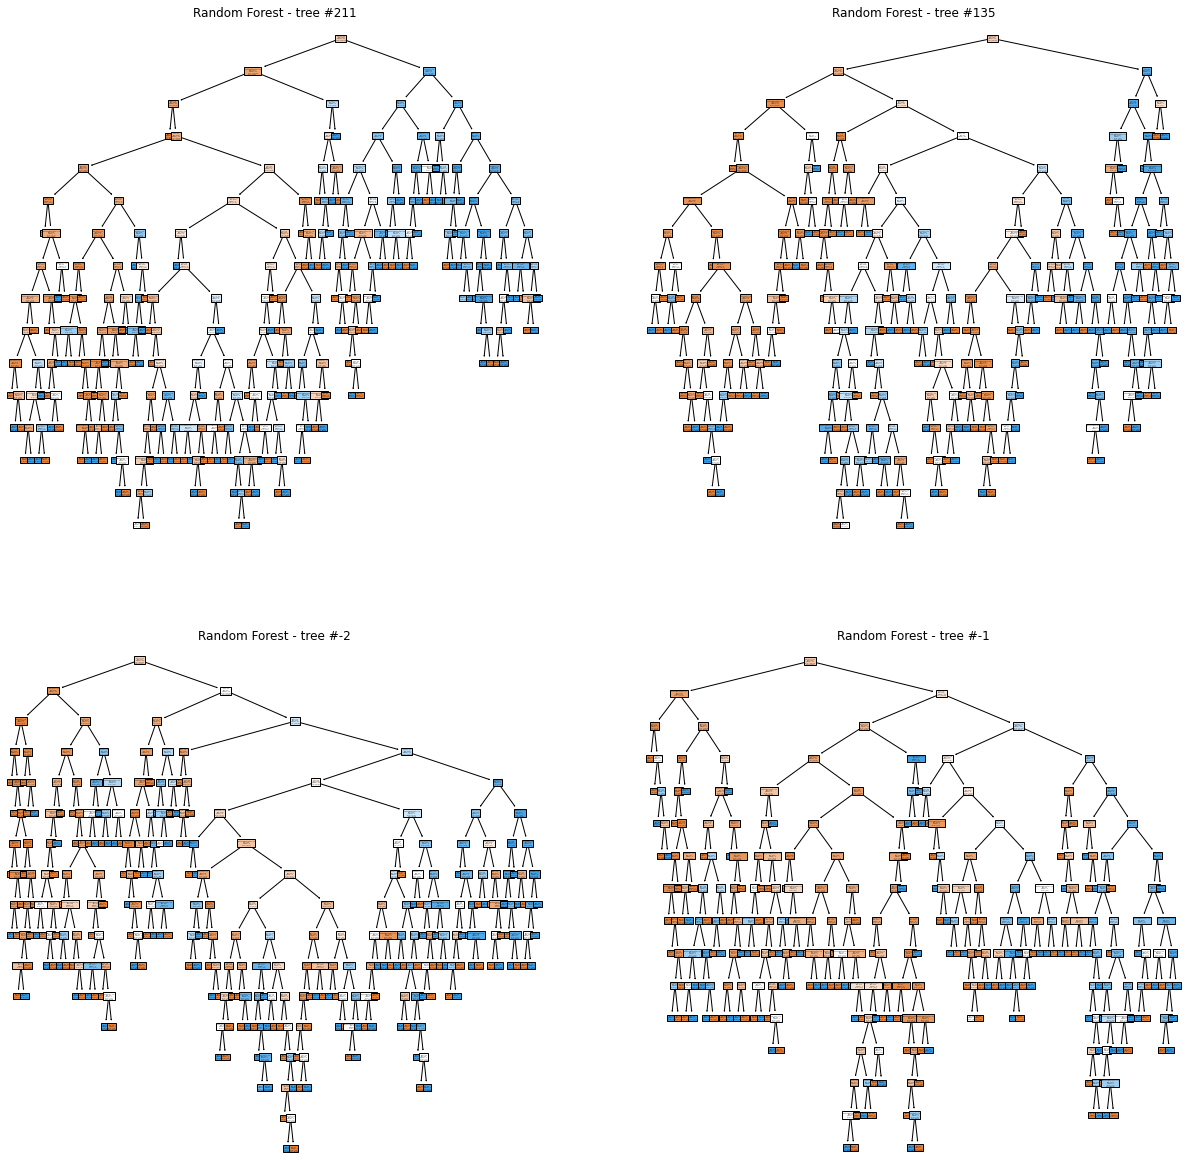

In [44]:
fig = plt.figure(figsize=(21, 21))

plt.subplot(221)
plot_tree(model_random_forest.estimators_[211], feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Random Forest - tree #211')

plt.subplot(222)
plot_tree(model_random_forest.estimators_[135], feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Random Forest - tree #135')

plt.subplot(223)
plot_tree(model_random_forest.estimators_[-2], feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Random Forest - tree #-2')

plt.subplot(224)
plot_tree(model_random_forest.estimators_[-1], feature_names=work_cols, class_names=class_labels, filled=True)
plt.title('Random Forest - tree #-1')

plt.show()

Никакой практической пользы в этом я не вижу. Однако нужно понимать, что случайный лес использует метод post pruning для каждого дерева, что вобщем-то видно.

**Naive Bayes**

In [45]:
model_naive_bayes = GaussianNB()

if isfile("./data/models/v2/model_naive_bayes.pkl"):
    with open("./data/models/v2/model_naive_bayes.pkl", "rb") as m_file:
        model_naive_bayes = pickle.load(m_file)
else:
    model_nb_best = GaussianNB()
    
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    best_score = 0
    
    for train_index, test_index in cross_val.split(work_constructed_df, src_df_class):
        X_train, X_test = work_constructed_df.iloc[train_index], work_constructed_df.iloc[test_index]
        y_train, y_test = src_df_class.iloc[train_index].to_numpy().flatten(), src_df_class.iloc[test_index].to_numpy().flatten()
        
        model_naive_bayes.fit(X_train, y_train)
        model_naive_bayes_pred = model_naive_bayes.predict(X_test)
        
        score = accuracy_score(y_test, model_naive_bayes_pred)
        
        if score > best_score:
            best_score = score
            model_nb_best = model_naive_bayes
    
    model_naive_bayes = model_nb_best
    with open("./data/models/v2/model_naive_bayes.pkl", "wb") as m_file:
        pickle.dump(model_nb_best, m_file)

In [46]:
naive_bayes_report = classification_report(
    y_true=y_constructed_test,
    y_pred=model_naive_bayes.predict(X_constructed_test), 
    output_dict=True
)

**Logistic Regression**

In [47]:
model_logistic_regression = LogisticRegression()

if isfile("./data/models/v2/model_logistic_regression.pkl"):
    with open("./data/models/v2/model_logistic_regression.pkl", "rb") as m_file:
        model_logistic_regression = pickle.load(m_file)
else:
    model_lr = LogisticRegression()
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='accuracy', error_score='raise', verbose=1)
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result = grid_search.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())
    
    model_logistic_regression = lr_result.best_estimator_
    
    with open("./data/models/v2/model_logistic_regression.pkl", "wb") as m_file:
        pickle.dump(lr_result, m_file)

In [48]:
logistic_regression_report = classification_report(
    y_true=y_constructed_test,
    y_pred=model_logistic_regression.predict(X_constructed_test), 
    output_dict=True
)

**SVC**

In [49]:
model_svc = SVC(probability=True)

if isfile("./data/models/v2/model_svc.pkl"):
    with open("./data/models/v2/model_svc.pkl", "rb") as m_file:
        model_svc = pickle.load(m_file)
else:
    c_values = np.arange(1, 20, 1)
    gamma_p = ['scale', 'auto']
    degree_p = np.arange(1, 10, 1)
    coef0_p = np.arange(0, 1, 0.1)
    
    params = [
        {'kernel': ['linear'], 'C': c_values},
        #{'kernel': ['poly'], 'C': c_values, 'degree': degree_p, 'gamma': gamma_p, 'coef0': coef0_p},
        {'kernel': ['rbf'], 'C': c_values, 'gamma': gamma_p},
        {'kernel': ['sigmoid'], 'C': c_values, 'gamma': gamma_p, 'coef0': coef0_p}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svc, param_grid=params, n_jobs=-1, cv=cross_val, scoring='accuracy', error_score='raise', verbose=1)
    svc_result = grid_search.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())
    
    model_svc = svc_result.best_estimator_
    
    with open("./data/models/v2/model_svc.pkl", "wb") as m_file:
        pickle.dump(model_svc, m_file)

In [50]:
svc_report = classification_report(
    y_true=y_constructed_test,
    y_pred=model_svc.predict(X_constructed_test), 
    output_dict=True
)

**KNN**

In [51]:
model_knn = KNeighborsClassifier()

if isfile("./data/models/v2/model_knn.pkl"):
    with open("./data/models/v2/model_knn.pkl", "rb") as m_file:
        model_knn = pickle.load(m_file)
else:
    n_neighbors = range(1, 21, 2)
    weights = ['uniform', 'distance']
    metric = ['euclidean', 'manhattan', 'minkowski']

    knn_params = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_knn, param_grid=knn_params, n_jobs=-1, cv=cross_val, scoring='accuracy', error_score='raise', verbose=1)
    knn_result = grid_search.fit(X_constructed_train.to_numpy(), y_constructed_train.to_numpy().flatten())
    
    model_knn = knn_result.best_estimator_
    
    with open("./data/models/v2/model_knn.pkl", "wb") as m_file:
        pickle.dump(model_knn, m_file)

In [52]:
knn_report = classification_report(
    y_true=y_constructed_test.to_numpy().flatten(),
    y_pred=model_knn.predict(X_constructed_test.to_numpy()), 
    output_dict=True
)

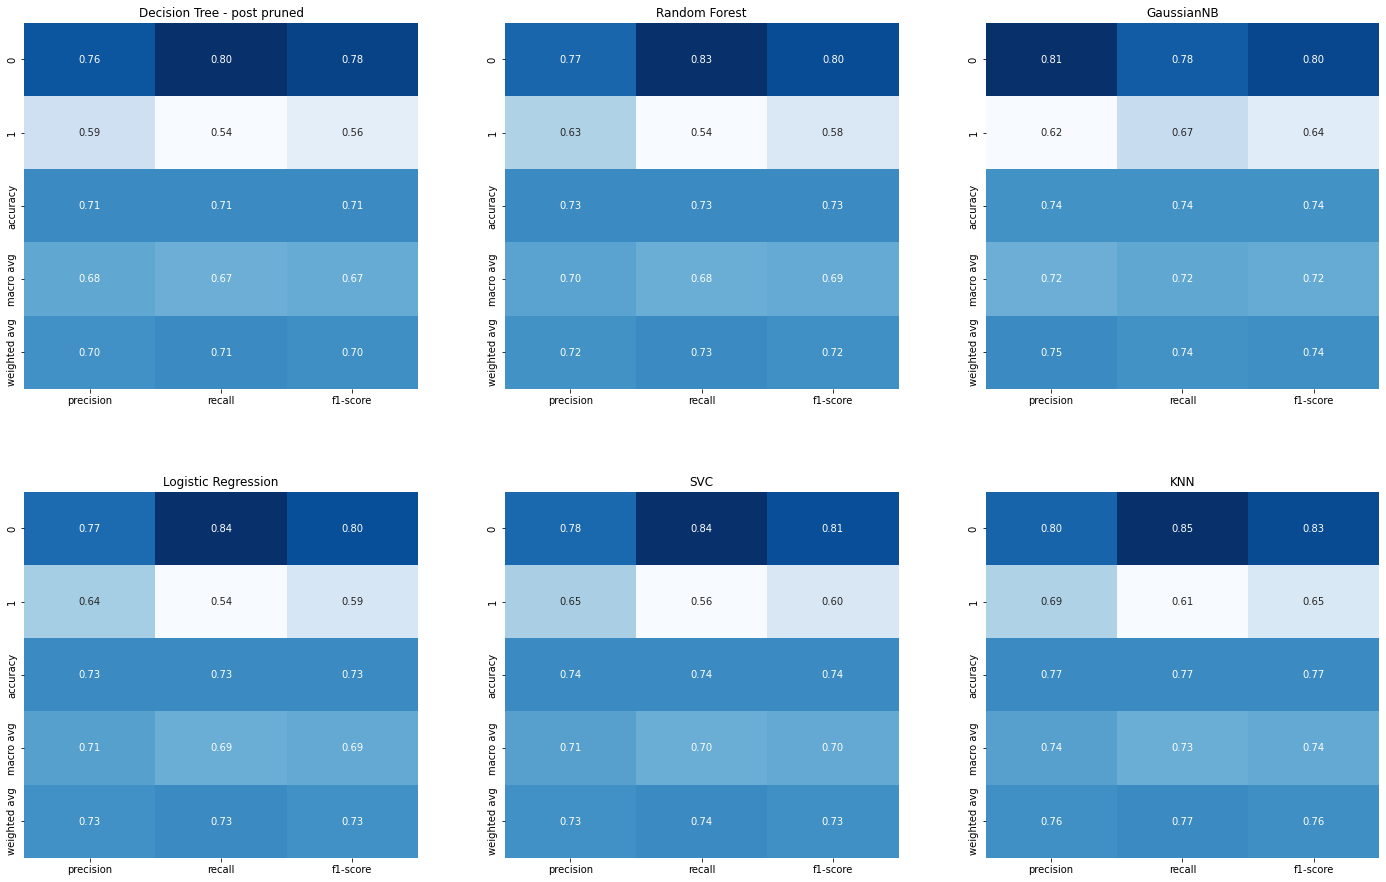

In [53]:
figure, ax = plt.subplots(2, 3, figsize=(21, 14))

axes = ax.flatten()

axes[0].set_title('Decision Tree - post pruned')
axes[1].set_title('Random Forest')
axes[2].set_title('GaussianNB')
axes[3].set_title('Logistic Regression')
axes[4].set_title('SVC')
axes[5].set_title('KNN')

sns.heatmap(pd.DataFrame(post_pruned_constructed_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[0])
sns.heatmap(pd.DataFrame(random_forest_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[1])
sns.heatmap(pd.DataFrame(naive_bayes_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[2])
sns.heatmap(pd.DataFrame(logistic_regression_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[3])
sns.heatmap(pd.DataFrame(svc_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[4])
sns.heatmap(pd.DataFrame(knn_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[5])

figure.tight_layout(pad=7.0)
plt.show()

In [54]:
ensemble_models = [
    ('GaussianNB', model_naive_bayes),
    ('Logistic Regression', model_logistic_regression),
    ('Decision Tree', model_tree_constructed_post_pruned),
    ('Random Forest', model_random_forest),
    ('SVC', model_svc),
    ('KNN', model_knn)
]

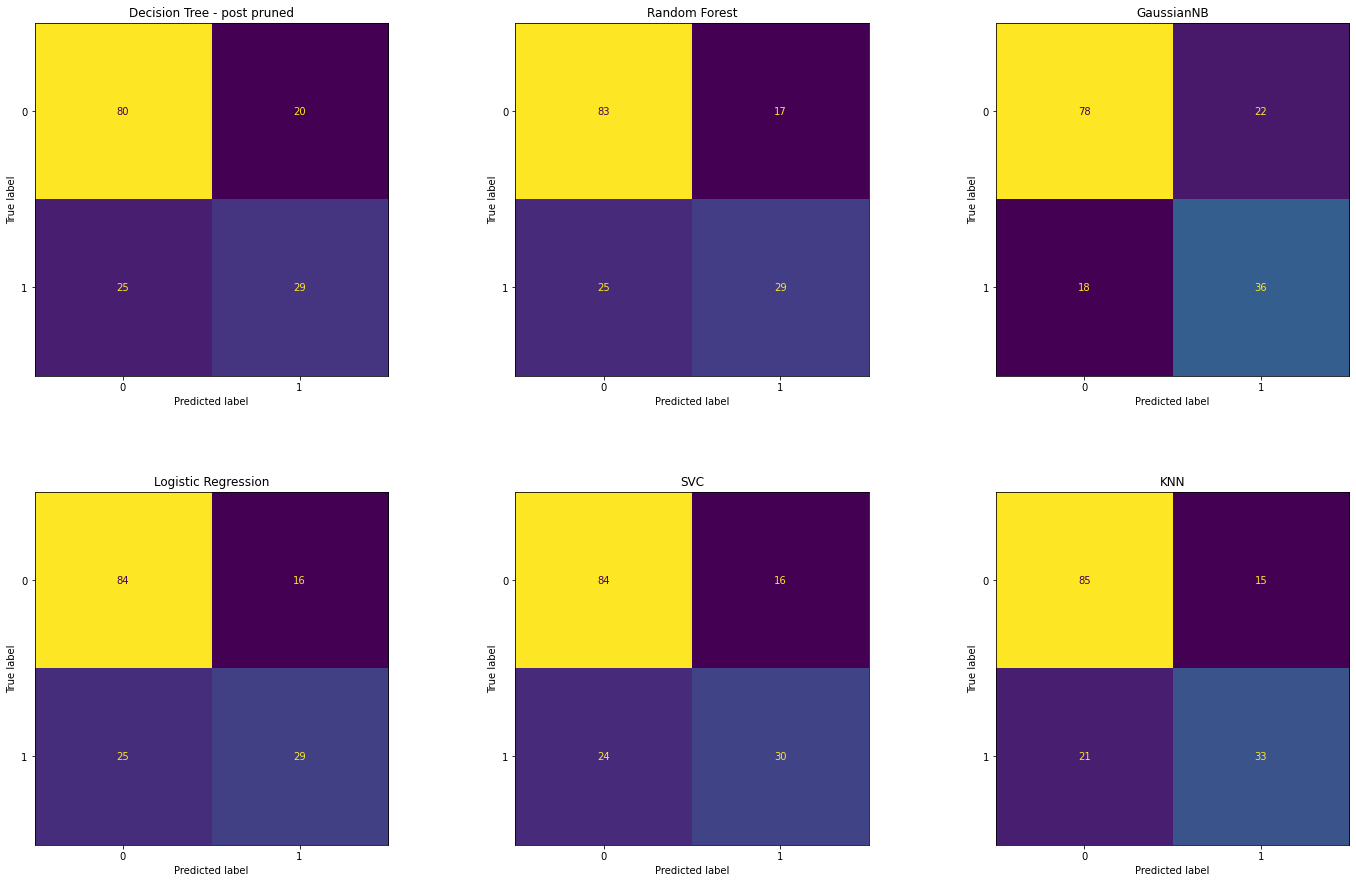

In [55]:
figure, ax = plt.subplots(2, 3, figsize=(21, 14))

axes = ax.flatten()

axes[0].set_title('Decision Tree - post pruned')
axes[1].set_title('Random Forest')
axes[2].set_title('GaussianNB')
axes[3].set_title('Logistic Regression')
axes[4].set_title('SVC')
axes[5].set_title('KNN')

ConfusionMatrixDisplay.from_estimator(estimator=model_tree_constructed_post_pruned, X=X_constructed_test, y=y_constructed_test, ax=axes[0], colorbar=False)
ConfusionMatrixDisplay.from_estimator(estimator=model_random_forest,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[1])
ConfusionMatrixDisplay.from_estimator(estimator=model_naive_bayes,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[2])
ConfusionMatrixDisplay.from_estimator(estimator=model_logistic_regression,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[3])
ConfusionMatrixDisplay.from_estimator(estimator=model_svc,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[4])
ConfusionMatrixDisplay.from_estimator(estimator=model_knn,  X=X_constructed_test.to_numpy(), y=y_constructed_test.to_numpy().flatten(), colorbar=False, ax=axes[5])

figure.tight_layout(pad=7.0)
plt.show()

Best Threshold for GaussianNB is 0.177973.
Best Threshold for Logistic Regression is 0.272935.
Best Threshold for Decision Tree is 0.357143.
Best Threshold for Random Forest is 0.292000.
Best Threshold for SVC is 0.306542.
Best Threshold for KNN is 0.368421.


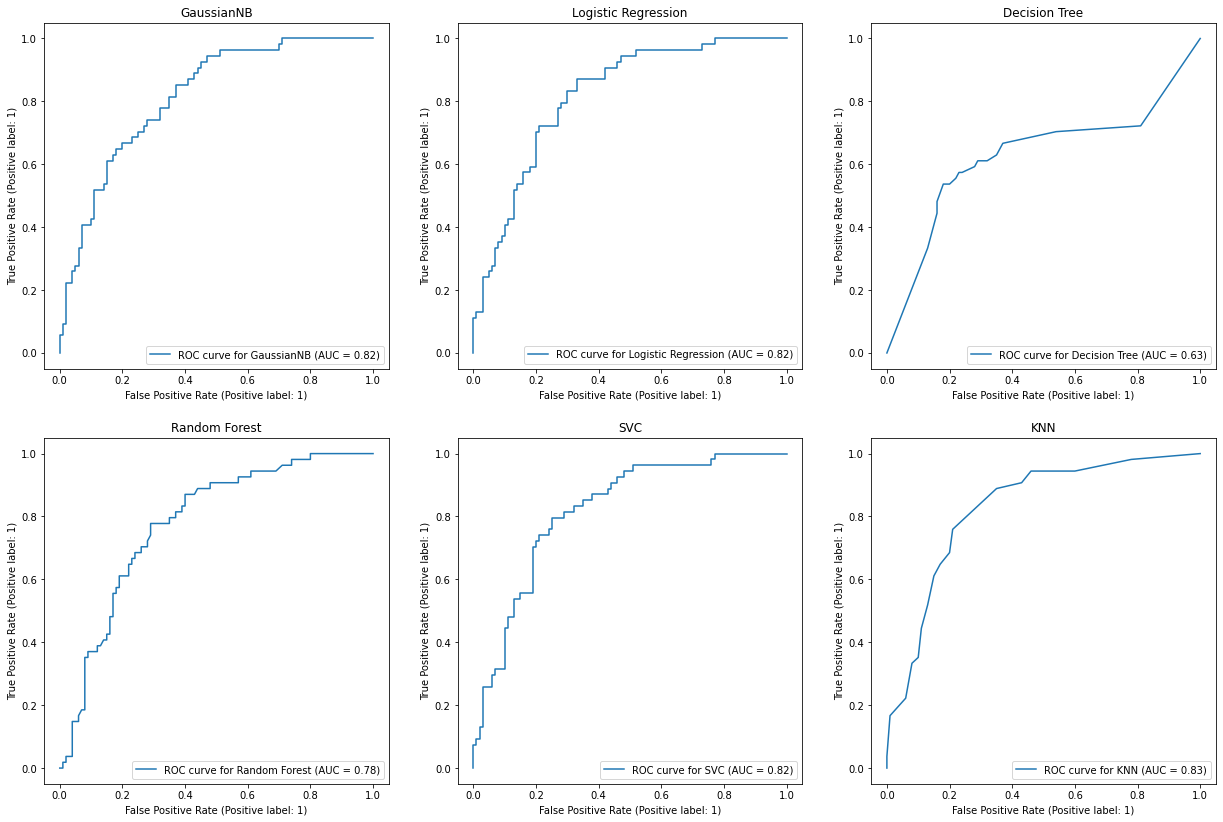

In [56]:
figure, ax = plt.subplots(2, 3, figsize=(21, 14))
axes = ax.flatten()

for idx, clf in enumerate(ensemble_models):
    RocCurveDisplay.from_estimator(
        estimator=clf[1],
        X=X_constructed_test, 
        y=y_constructed_test,
        name=str("ROC curve for " + clf[0]),
        ax=axes[idx]
    )
    axes[idx].set_title(clf[0])
    
    fpr, tpr, thresholds = roc_curve(y_constructed_test, clf[1].predict_proba(X_constructed_test)[:, 1])
    gmeans = sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print("Best Threshold for {} is {:.6f}.".format(clf[0], thresholds[ix]))

In [57]:
print("AUC for: ")

for clf in ensemble_models:
    current_auc = roc_auc_score(
        y_constructed_test,
        clf[1].predict_proba(X_constructed_test)[:, 1]
    )
    print(" - {}: {:.6f}".format(clf[0], current_auc))

print("Accuracy for: ")

for clf in ensemble_models:
    current_acc = roc_auc_score(
        y_constructed_test,
        clf[1].predict(X_constructed_test)
    )
    print(" - {}: {:.6f}".format(clf[0], current_acc))


AUC for: 
 - GaussianNB: 0.816296
 - Logistic Regression: 0.817963
 - Decision Tree: 0.628426
 - Random Forest: 0.779815
 - SVC: 0.819074
 - KNN: 0.826389
Accuracy for: 
 - GaussianNB: 0.723333
 - Logistic Regression: 0.688519
 - Decision Tree: 0.668519
 - Random Forest: 0.683519
 - SVC: 0.697778
 - KNN: 0.730556


Тут ничего неожиданного. Ни одна модель не выдает особо высокой точности. Но и аномалий тоже нет.

## **Ensemble**

Я не буду использовать bagging отдельно, поскольку случайный лес это он и есть. 

**Stacking ensemble - one layer**

In [58]:
ensemble_st_ol = StackingClassifier(estimators=ensemble_models, n_jobs=-1)

if isfile("./data/models/v2/ensemble_st_ol.pkl"):
    with open("./data/models/v2/ensemble_st_ol.pkl", "rb") as m_file:
        ensemble_st_ol = pickle.load(m_file)
else:
    with ignore_warnings(category=ConvergenceWarning):
        ensemble_st_ol.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())
    
    with open("./data/models/v2/ensemble_st_ol.pkl", "wb") as m_file:
        pickle.dump(ensemble_st_ol, m_file)

In [59]:
st_ol_report = classification_report(
    y_true=y_constructed_test.to_numpy().flatten(),
    y_pred=ensemble_st_ol.predict(X_constructed_test), 
    output_dict=True
)

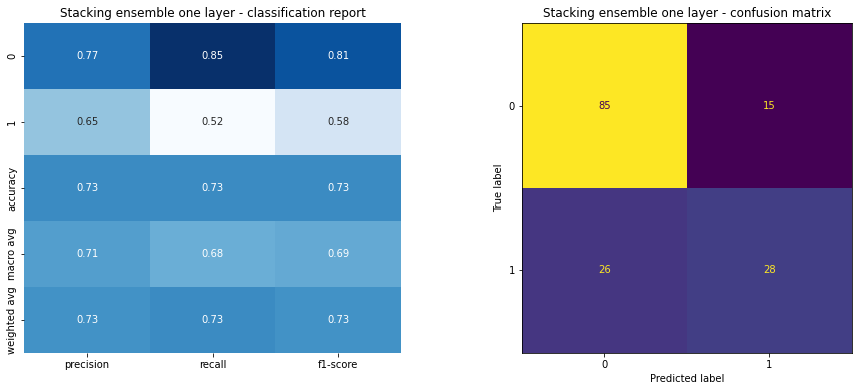

In [60]:
figure, ax = plt.subplots(1, 2, figsize=(14, 7))

axes = ax.flatten()

axes[0].set_title('Stacking ensemble one layer - classification report')
axes[1].set_title('Stacking ensemble one layer - confusion matrix')

sns.heatmap(pd.DataFrame(st_ol_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(estimator=ensemble_st_ol,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[1])

figure.tight_layout(pad=7.0)
plt.show()

**Stacking ensemble - two layers**

In [61]:
ensemble_models_layer_one = [
    ('GaussianNB', model_naive_bayes),
    ('Logistic Regression', model_logistic_regression),
    ('Decision Tree', model_tree_constructed_post_pruned),
]

ensemble_models_layer_two = [
    ('Random Forest', model_random_forest),
    ('SVC', model_svc),
    ('KNN', model_knn)
]

In [62]:
layer_two_estimator = StackingClassifier(estimators=ensemble_models_layer_two, n_jobs=-1, final_estimator=GaussianNB())
ensemble_st_ml = StackingClassifier(estimators=ensemble_models_layer_one, n_jobs=-1, final_estimator=layer_two_estimator)

In [63]:
if isfile("./data/models/v2/ensemble_st_ml.pkl"):
    with open("./data/models/v2/ensemble_st_ml.pkl", "rb") as m_file:
        ensemble_st_ml = pickle.load(m_file)
else:
    with ignore_warnings(category=ConvergenceWarning):
        ensemble_st_ml.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())
    
    with open("./data/models/v2/ensemble_st_ml.pkl", "wb") as m_file:
        pickle.dump(ensemble_st_ml, m_file)

In [64]:
st_ml_report = classification_report(
    y_true=y_constructed_test.to_numpy().flatten(),
    y_pred=ensemble_st_ml.predict(X_constructed_test), 
    output_dict=True
)

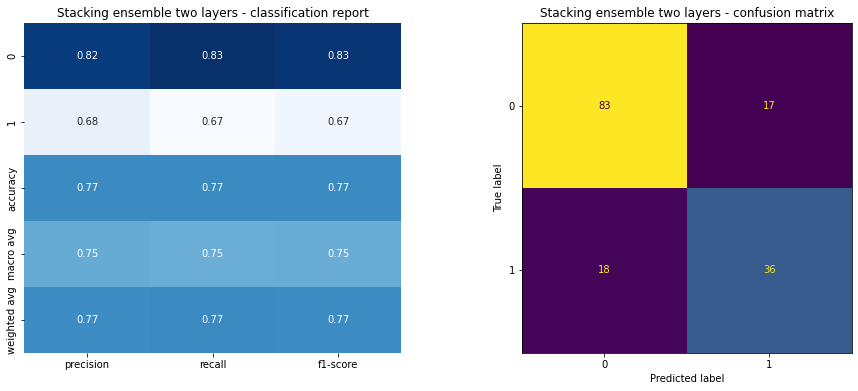

In [65]:
figure, ax = plt.subplots(1, 2, figsize=(14, 7))

axes = ax.flatten()

axes[0].set_title('Stacking ensemble two layers - classification report')
axes[1].set_title('Stacking ensemble two layers - confusion matrix')

sns.heatmap(pd.DataFrame(st_ml_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(estimator=ensemble_st_ml,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[1])

figure.tight_layout(pad=7.0)
plt.show()

In [66]:
print("AUC for one layer Stacking Ensemble: {:.6f}".format(roc_auc_score(y_constructed_test, ensemble_st_ol.predict_proba(X_constructed_test)[:, 1])))
print("AUC for two layers Stacking Ensemble: {:.6f}".format(roc_auc_score(y_constructed_test, ensemble_st_ml.predict_proba(X_constructed_test)[:, 1])))
print("Accuracy for one layer Stacking Ensemble: {:.6f}".format(accuracy_score(y_constructed_test, ensemble_st_ol.predict(X_constructed_test))))
print("Accuracy for two layers Stacking Ensemble: {:.6f}".format(accuracy_score(y_constructed_test, ensemble_st_ml.predict(X_constructed_test))))

AUC for one layer Stacking Ensemble: 0.818889
AUC for two layers Stacking Ensemble: 0.811111
Accuracy for one layer Stacking Ensemble: 0.733766
Accuracy for two layers Stacking Ensemble: 0.772727


Best Threshold for One Layer is 0.339713.
Best Threshold for Two Layers is 0.575102.


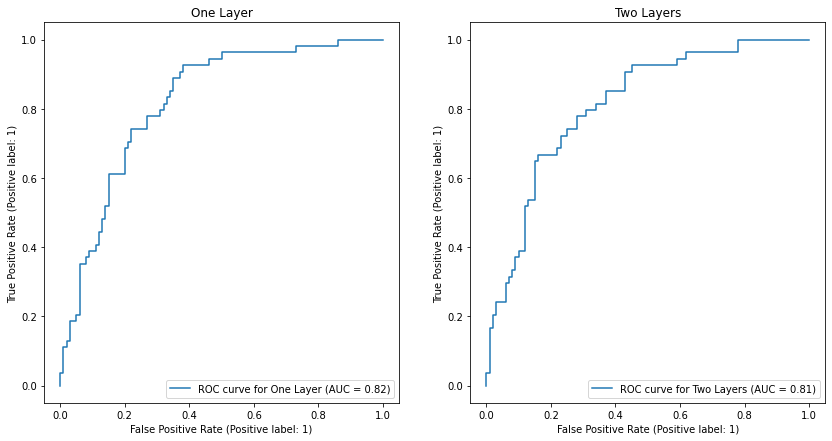

In [67]:
ensemble_models_st = [
    ('One Layer', ensemble_st_ol),
    ('Two Layers', ensemble_st_ml)
]

figure, ax = plt.subplots(1, 2, figsize=(14, 7))
axes = ax.flatten()

for idx, clf in enumerate(ensemble_models_st):
    RocCurveDisplay.from_estimator(
        estimator=clf[1],
        X=X_constructed_test, 
        y=y_constructed_test,
        name=str("ROC curve for " + clf[0]),
        ax=axes[idx]
    )
    axes[idx].set_title(clf[0])
    
    fpr, tpr, thresholds = roc_curve(y_constructed_test, clf[1].predict_proba(X_constructed_test)[:, 1])
    gmeans = sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print("Best Threshold for {} is {:.6f}.".format(clf[0], thresholds[ix]))

В два слоя получилось хорошо. Хоть и пальцем в небо, поскольку я пока не знаю как подбирать гетерогенные модели, но неплохо.

**Voting classifier**

In [68]:
ensemble_voting = VotingClassifier(
    estimators=ensemble_models,
    n_jobs=-1,
    verbose=1,
    voting='soft'
)

In [69]:
if isfile("./data/models/v2/ensemble_voting.pkl"):
    with open("./data/models/v2/ensemble_voting.pkl", "rb") as m_file:
        ensemble_voting = pickle.load(m_file)
else:
    with ignore_warnings(category=ConvergenceWarning):
        ensemble_voting.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())
    
    with open("./data/models/v2/ensemble_voting.pkl", "wb") as m_file:
        pickle.dump(ensemble_voting, m_file)

In [70]:
print("AUC for Voting Ensemble: {:.6f}".format(roc_auc_score(y_constructed_test, ensemble_voting.predict_proba(X_constructed_test)[:, 1])))
print("Accuracy for Voting Ensemble: {:.6f}".format(accuracy_score(y_constructed_test, ensemble_voting.predict(X_constructed_test))))

AUC for Voting Ensemble: 0.809815
Accuracy for Voting Ensemble: 0.753247


In [71]:
voting_report = classification_report(
    y_true=y_constructed_test.to_numpy().flatten(),
    y_pred=ensemble_voting.predict(X_constructed_test), 
    output_dict=True
)

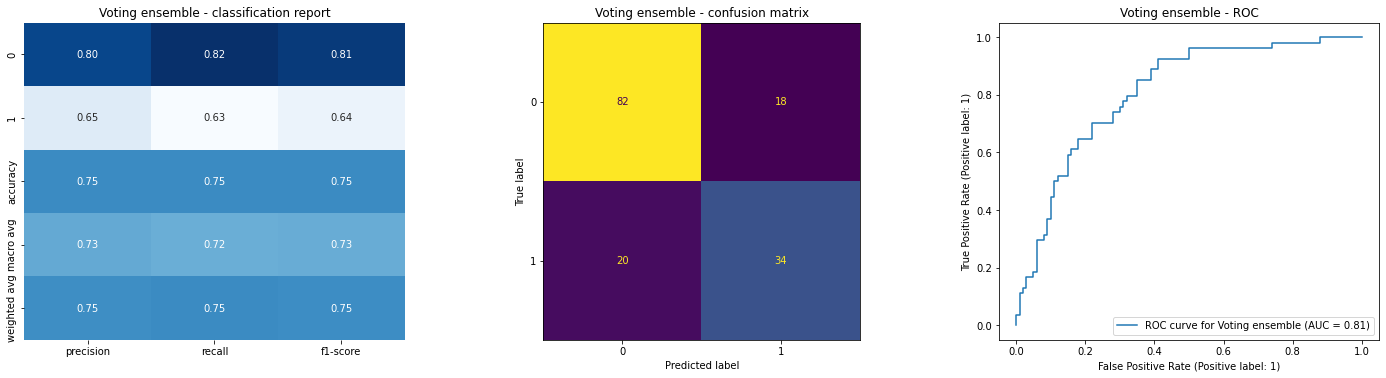

In [72]:
figure, ax = plt.subplots(1, 3, figsize=(21, 7))

axes = ax.flatten()

axes[0].set_title('Voting ensemble - classification report')
axes[1].set_title('Voting ensemble - confusion matrix')
axes[2].set_title('Voting ensemble - ROC')

sns.heatmap(pd.DataFrame(voting_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(estimator=ensemble_voting,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[1])
RocCurveDisplay.from_estimator(estimator=ensemble_voting, X=X_constructed_test, y=y_constructed_test, name=str("ROC curve for Voting ensemble"), ax=axes[2])

figure.tight_layout(pad=7.0)
plt.show()

**AdaBoost**

In [73]:
ensemble_ada = AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42)

In [74]:
if isfile("./data/models/v2/ensemble_ada.pkl"):
    with open("./data/models/v2/ensemble_ada.pkl", "rb") as m_file:
        ensemble_ada = pickle.load(m_file)
else:
    with ignore_warnings(category=ConvergenceWarning):
        ensemble_ada.fit(X_constructed_train, y_constructed_train.to_numpy().flatten())
    
    with open("./data/models/v2/ensemble_ada.pkl", "wb") as m_file:
        pickle.dump(ensemble_ada, m_file)

In [75]:
print("AUC for Ada Boost Ensemble: {:.6f}".format(roc_auc_score(y_constructed_test, ensemble_ada.predict_proba(X_constructed_test)[:, 1])))
print("Accuracy for Ada Boost Ensemble: {:.6f}".format(accuracy_score(y_constructed_test, ensemble_ada.predict(X_constructed_test))))

AUC for Ada Boost Ensemble: 0.780185
Accuracy for Ada Boost Ensemble: 0.649351


In [76]:
ada_report = classification_report(
    y_true=y_constructed_test.to_numpy().flatten(),
    y_pred=ensemble_ada.predict(X_constructed_test), 
    output_dict=True
)

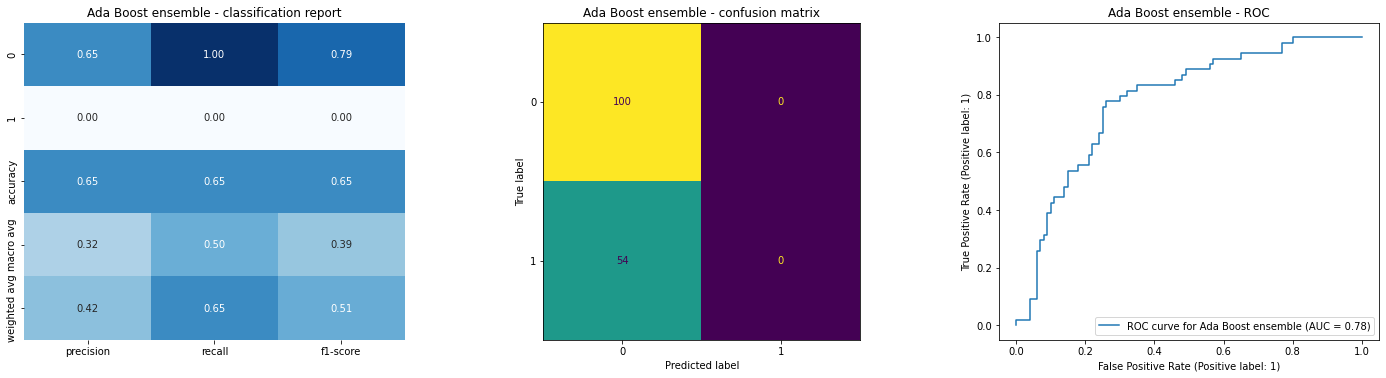

In [77]:
figure, ax = plt.subplots(1, 3, figsize=(21, 7))

axes = ax.flatten()

axes[0].set_title('Ada Boost ensemble - classification report')
axes[1].set_title('Ada Boost ensemble - confusion matrix')
axes[2].set_title('Ada Boost ensemble - ROC')

sns.heatmap(pd.DataFrame(ada_report).iloc[:-1, :].T, annot=True, fmt='.2f', square=False, cmap = 'Blues', cbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(estimator=ensemble_ada,  X=X_constructed_test, y=y_constructed_test, colorbar=False, ax=axes[1])
RocCurveDisplay.from_estimator(estimator=ensemble_ada, X=X_constructed_test, y=y_constructed_test, name=str("ROC curve for Ada Boost ensemble"), ax=axes[2])

figure.tight_layout(pad=7.0)
plt.show()

Очень интересно, почему так получилось...

## **Заключение**

Деревья интересный алгоритм. Главное его достоинство, на мой взгляд, отличная возможность интерпретировать.

Как всегда, каждый алгоритм хорош в своей нише. В данной задаче лучше всех был KNN. Нет серебрянной пули, как это ни прискорбно.

Ансамблирование хорошая методика. Удалось вытащить дополнительных четыре сотых на accuracy в сравнении с KNN. А это немало. Но эту тему ещё нужно изучать.

Я не пытался особо точно настроить ансамбли, поскольку не очень хорошо их на данный момент понимаю. Думаю, при грамотном подходе, можно из них вытащить больше.

Очень интересно было посмотреть, как шагнули технологии с 1988го года. То, что требовало больших усилий и серьезных специалистов 33 года назад, сейчас можно сделать в рамках домашней работы, на компьютере позапрошлого поколения.